In [1]:
import sys
import numpy as np
import os
from image_utils import standardize
from IOU_computations import *
from numpy import newaxis
import matplotlib.pyplot as plt
from dataset_generator_2 import Dataset_sat

from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
from resunet_main import predict,criterion
import torch.backends.cudnn as cudnn

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

INPUT_CHANNELS=9
NB_CLASSES=2
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32



In [3]:
def plot_summary(predictions,labels,pansharp,batch_size,batch_number,prediction_path,display='all'):
    
    if display=='all':
        fig,axs=plt.subplots(3, batch_size,figsize=(8*batch_size,24))

        axs[0,0].set_title(str(batch_number)+' Pansharpened ', fontsize='large')
        axs[1,0].set_title(str(batch_number)+' Groundtruth ', fontsize='large')
        axs[2,0].set_title(str(batch_number)+' Predictions ', fontsize='large')


        for i in range(batch_size):

            axs[0,i].imshow(pansharp[i])
#             plt.imsave(prediction_path+'_'+str(batch_number)+'_Pansharpened_'+str(i)+'.jpg',pansharp[i])
            axs[1,i].imshow(labels[i])
#             plt.imsave(prediction_path+'_'+str(batch_number)+'_Groundtruth_'+str(i)+'.jpg',labels[i])
            axs[2,i].imshow(predictions[i])
#             plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',predictions[i])
    
    else:
        fig,axs=plt.subplots(1, batch_size,figsize=(8*batch_size,24))
        axs[0].set_title(str(batch_number)+' Predictions ', fontsize='large')
        for i in range(batch_size):
            axs[i].imshow(predictions[i])
#             plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',predictions[i])
        

    plt.show()



In [4]:
def generate_dataset(path_validation,validation_batch_size):
    val_generator=Dataset_sat.from_root_folder(path_validation,NB_CLASSES,max_data_size=200)
    val_loader = DataLoader(val_generator, batch_size=validation_batch_size,shuffle=False, num_workers=1)
    
    return val_loader

In [5]:
def predict_pytorch_val(val_loader,number_iterations,restore_path,prediction_path,display):
    TMP_IOU=prediction_path+'TMP_IOU/'
    if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)
    loss_fn=nn.CrossEntropyLoss()
    

    model=UNet(INPUT_CHANNELS,NB_CLASSES,DEFAULT_LAYERS,DEFAULT_FEATURES_ROOT,0)
    model.cuda()
    cudnn.benchmark = True
    model.load_state_dict(torch.load(restore_path))
    
    optimizer=optim.Adam(model.parameters(),lr=0.001)
    counter=0
    for i_batch,sample_batch in enumerate(val_loader):
        X_val=standardize(sample_batch['input'])
        Y_val=sample_batch['groundtruth']

        predictions=[]
        for j in range(len(X_val)):
            X_val_j=X_val[j]
            X_val_j=X_val_j[newaxis,:,:,:]
            X_val_j=standardize(X_val_j)
            Y_val_j=Y_val[j]
            Y_val_j=Y_val_j[newaxis,:,:,:]
            
            X = Variable(X_val_j.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(Y_val_j.float())
            Y=Y.cuda()  
            
            predictions_i=predict(model,X,optimizer)
#             print(predictions_i)
            loss_i=criterion(Y,predictions_i)
            loss_i=loss_i.data[0]
            predictions_i=predictions_i.data.cpu().numpy()
            Y_val_j=np.asarray(Y_val_j)
            iou_acc_v,f1_v,iou_v=predict_score_batch(TMP_IOU,np.argmax(Y_val_j,3),np.argmax(predictions_i,3))
#             print("Image {:d}, Validation IoU {:.4f}, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%, loss {:.8f}".format(j,iou_v,iou_acc_v,f1_v,loss_i))
            predictions.append(predictions_i)
            
        predictions=np.squeeze(np.asarray(predictions))
        X_val=np.asarray(X_val)
        Y_val=np.asarray(Y_val)
        pansharp=np.stack((X_val[:,:,:,5],X_val[:,:,:,3],X_val[:,:,:,2]),axis=3)
        plot_summary(np.argmax(predictions,3),np.argmax(Y_val,3),pansharp,len(X_val),counter,prediction_path,display)
        counter+=1
        if counter==number_iterations:
            break
            
        
        

VAL GHANA


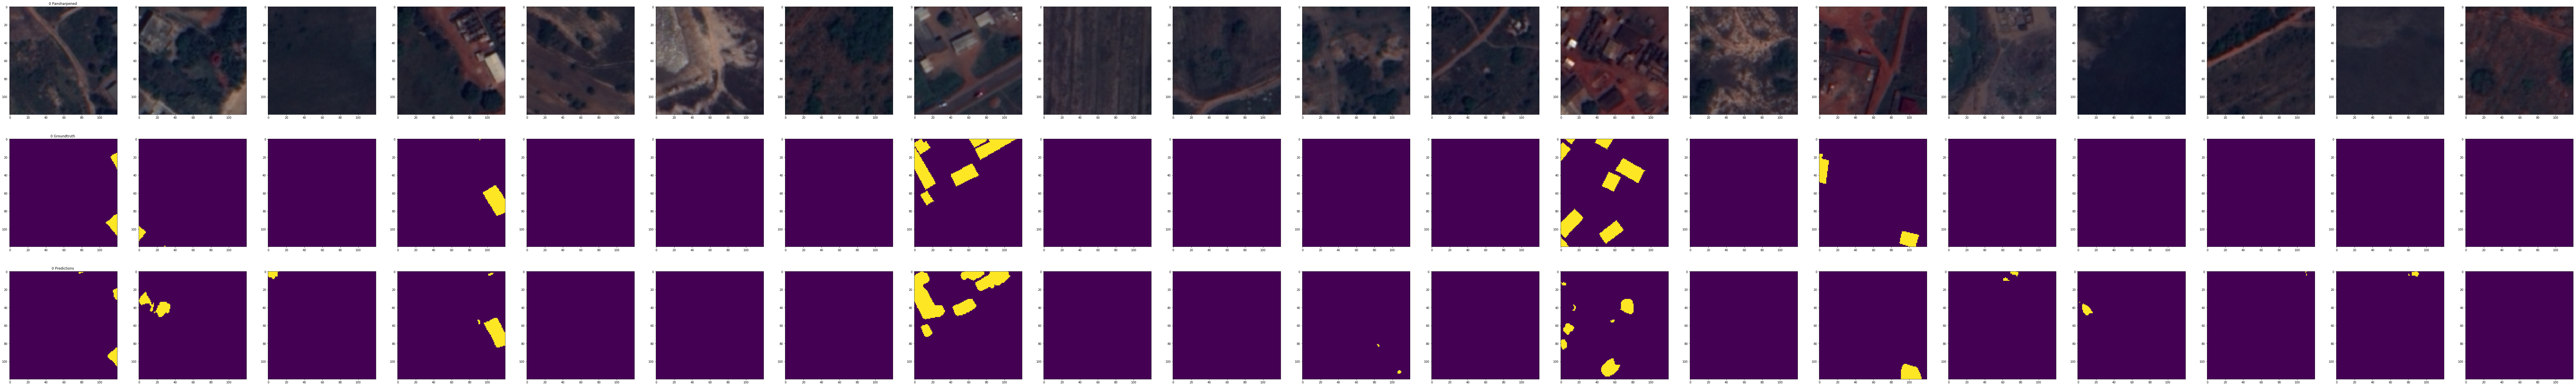

MELI GHANA


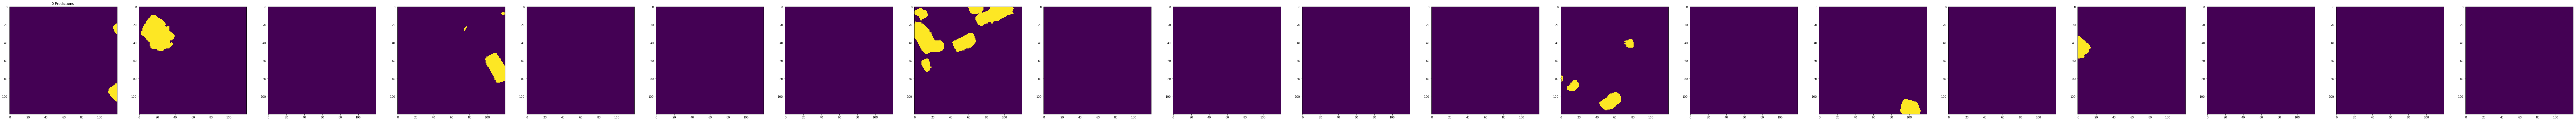

In [8]:
if __name__ == '__main__':
    
    
    
    root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'
    
    validation_loader=generate_dataset(root_folder+'VALIDATION/',20)
    
    
    
#     ####SPACENET MELI#######
    
#     root_folder ='/scratch/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/'
#     validation_loader=generate_dataset(root_folder+'TEST/',30)
    

    
#     prediction_path='VISUALIZATION_IMAGES/MELI_SPACENET/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)

#     print('SPACENET MELI')

#     predict_pytorch_val(validation_loader,3,'MODEL_MELI_SPACENET/RESUNET_meli_spacenet.ckptCP9000.pth',prediction_path,'all')

     #####VAL GHANA########
    
    from unet_val import UNet

    prediction_path='VISUALIZATION_IMAGES/VAL_GHANA/'

    if not os.path.exists(prediction_path):
            os.makedirs(prediction_path)


    print('VAL GHANA')
    predict_pytorch_val(validation_loader,1,'MODEL_VAL_GHANA/RESUNET_pytorch_val_ghana_restored.ckptCP30000.pth',prediction_path,'all')
    
    #####MELI GHANA ########
    from unet_meli import UNet
    prediction_path='VISUALIZATION_IMAGES/MELI_GHANA/'

    if not os.path.exists(prediction_path):
            os.makedirs(prediction_path)


    print('MELI GHANA')
    predict_pytorch_val(validation_loader,1,'MODEL_MELI_GHANA/RESUNET_pytorch_meli_ghana_restored.ckptCP28000.pth',prediction_path,'no')
    
    
   